In [1]:
import os
import sys
import time

import numpy as np

from pstools.rambo import dot

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import activations

from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
# NB .legacy below something specific to M1/M2 Apple chips 
#from keras.optimizers.legacy import Adam
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

2023-11-28 11:49:51.899369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## FKS sectors for Neural Networks amplitude approximations ##

Using the same e+e- -> jets data as before, we investigate if the amplitude approxiamtion can be improved by partial fractioning the amplitude according to FKS sectors which isolate the singularities.

# Aim #



# Step 1: Choose process and select training data

In [2]:
loop = 0
jets = 3
delta_cut = 0.03

In [3]:
NJdata = np.load("data/NJdata_"+str(loop)+"L_ee"+str(jets)+"j_d"+str(delta_cut)+".npz")
print(NJdata.files)

mom_data = NJdata['momenta']
amp_data = NJdata['NJ_vals']

['momenta', 'NJ_vals']


In [4]:
# choose the number of training points (will later be split into NN train/validation set)
n_points = len(amp_data)
print("found", n_points, "data points")

n_training_points = 100000
# choose the number of points for interpolation tests after training
# NB - different from the training/validation split during training
n_test_points = min(900000, n_points-n_training_points)

print("will train/validate on",n_training_points,"then test on",n_test_points)

found 1000000 data points
will train/validate on 100000 then test on 900000


In [5]:
mom_train = mom_data[:n_training_points]
amp_train = amp_data[:n_training_points]

In [6]:
def mean_and_std(myarray, axis=0):
    return np.mean(myarray, axis=axis), np.std(myarray, axis=axis)

In [7]:
def standardize(myarray, ave, std):
    return (myarray-ave)/std

def destandardize(myarray, ave, std):
    return myarray*std+ave

# Setup and train set of models

In [8]:
# another option is to use the 3*n-10 independent invariants as input
# this attempts to account for the Poincare' redundancy in the Lorentz vector representation
def momenta2invariants(mm):
    if len(mm)==4: # s,t
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2])])
    elif len(mm)==5: # s12,s23,s34,s45,s15
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2]),
            dot(mm[2], mm[3]),dot(mm[3], mm[4]),
            dot(mm[4], mm[0])])
    elif len(mm)==6: # s12,s23,s34,s45,s56,s16,s123,s234
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2]),
            dot(mm[2], mm[3]),dot(mm[3], mm[4]),
            dot(mm[4], mm[5]),dot(mm[5], mm[0]),
            dot(mm[0], mm[1])+dot(mm[1], mm[2])+dot(mm[0], mm[2]),
            dot(mm[1], mm[2])+dot(mm[2], mm[3])+dot(mm[1], mm[3])
        ])
    else:
        print("only n = 4,5,6 implemented")
        
    return invariants
        

In [9]:
inv_train = np.array([momenta2invariants(mm) for mm in mom_train])

In [10]:
# as we are have e+e- with fixed centre-of-mass energy the
# invariant (p0+p1)^2 = 2*p0.p1 is constant and can be eliminated
inv_ave, inv_std = mean_and_std(inv_train[:,1:],axis=0)
inv_stdized = standardize(inv_train[:,1:], inv_ave, inv_std)

In [11]:
def getFKSpartitions(mom):
    nn = len(mom)
    ss = [];
    for i in range(2,nn-1):
        for j in range(i+1,nn):
            #print(i, j, i-2+(j-2)*(j-3)/2)
            ss.append(2*dot(mom[i],mom[j]))
    ss = np.array(ss)
    DD = np.sum(1/ss)
    SS = 1/ss/DD
    return(SS)

In [12]:
# example of FKS partitions for the first phasespace point
FKS_partitions = getFKSpartitions(mom_train[0])
n_FKSsectors = len(FKS_partitions)
print(FKS_partitions)
print(np.sum(FKS_partitions))

[0.0742761  0.34133044 0.58439346]
1.0


In [13]:
FKS_partitions_train = np.array([getFKSpartitions(mm) for mm in mom_train])
ampFKS_train = np.array([FKS_partitions_train[ii]*amp_train[ii] for ii in range(len(amp_train))])

In [14]:
# the standardized the amplitude values as well
amp_ave = np.mean(amp_train)
amp_std = np.std(amp_train)
amp_stdized = standardize(amp_train,amp_ave,amp_std)

In [15]:
# the standardized the FKS partitioned amplitude values
ampFKS_ave = np.mean(amp_train,axis=0)
ampFKS_std = np.std(amp_train,axis=0)
ampFKS_stdized = standardize(ampFKS_train,ampFKS_ave,ampFKS_std)

In [16]:
# check all the values are consistent
print(destandardize(ampFKS_stdized[0], ampFKS_ave, ampFKS_std))
print(np.sum(destandardize(ampFKS_stdized[0], ampFKS_ave, ampFKS_std)))
print(destandardize(amp_stdized[0],amp_ave,amp_std))

[0.00647765 0.02976758 0.05096521]
0.08721043585628394
0.08721043585628394


In [17]:
def model_init(inv_stdized, layers):
    input_size = len(inv_stdized[0])
    input_values = inv_stdized

    model = Sequential()

    model.add(Dense(
        layers[0], input_dim=(input_size), kernel_initializer = glorot_uniform(seed=1)
    ))
    model.add(Activation(activations.tanh))
        
    for layer in range(1, len(layers)):
        model.add(Dense(layers[layer]))
        model.add(Activation(activations.tanh))

    model.add(Dense(
        1, kernel_initializer = glorot_uniform(seed=len(layers))
        ))
    # Compile model
    model.compile(
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
        loss = 'mean_squared_error'
    )
    return model

def modelFKS_init(inv_stdized, layers):
    input_size = len(inv_stdized[0])
    input_values = inv_stdized

    model = Sequential()

    model.add(Dense(
        layers[0], input_dim=(input_size), kernel_initializer = glorot_uniform(seed=1)
    ))
    model.add(Activation(activations.tanh))
        
    for layer in range(1, len(layers)):
        model.add(Dense(layers[layer]))
        model.add(Activation(activations.tanh))

    model.add(Dense(
        n_FKSsectors, kernel_initializer = glorot_uniform(seed=len(layers))
        ))
    # Compile model
    model.compile(
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
        loss = 'mean_squared_error'
    )
    return model

In [18]:
model = []
n_ensemble = 2
for mm in range(n_ensemble):
    model.append(model_init(inv_stdized, [20,40,20]))

modelFKS = []
n_ensemble = 2
for mm in range(n_ensemble):
    modelFKS.append(modelFKS_init(inv_stdized, [20,40,20]))

2023-11-28 11:49:59.463362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
ES = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=1,
    restore_best_weights=True
)

In [20]:
history = []
for mm in range(n_ensemble):
    
    print('starting training of model', mm);
    start_time = time.time();
    
    input_train, input_val, output_train, output_val = train_test_split(
        inv_stdized, amp_stdized, test_size=0.2)
    
    history.append(model[mm].fit(
        input_train, output_train,
        validation_data=(input_val, output_val),
        batch_size=512,
        epochs=10000,
        verbose=0,
        shuffle=False,
        callbacks=[ES]
    ))

    print(f'Best case loss: {ES.best}')
    
    print('finished in ', time.time()-start_time)

starting training of model 0
Restoring model weights from the end of the best epoch: 179.
Epoch 279: early stopping
Best case loss: 0.003817280288785696
finished in  56.74705529212952
starting training of model 1
Restoring model weights from the end of the best epoch: 545.
Epoch 645: early stopping
Best case loss: 0.00031403364846482873
finished in  132.1955587863922


In [21]:
historyFKS = []
for mm in range(n_ensemble):
    
    print('starting training of model', mm);
    start_time = time.time();
    
    input_train, input_val, output_train, output_val = train_test_split(
        inv_stdized, ampFKS_stdized, test_size=0.2)
    
    historyFKS.append(modelFKS[mm].fit(
        input_train, output_train,
        validation_data=(input_val, output_val),
        batch_size=512,
        epochs=10000,
        verbose=0,
        shuffle=False,
        callbacks=[ES]
    ))

    print(f'Best case loss: {ES.best}')
    
    print('finished in ', time.time()-start_time)

starting training of model 0
Restoring model weights from the end of the best epoch: 715.
Epoch 815: early stopping
Best case loss: 0.0001133065452449955
finished in  161.8864622116089
starting training of model 1
Restoring model weights from the end of the best epoch: 575.
Epoch 675: early stopping
Best case loss: 8.641197928227484e-05
finished in  136.25167202949524


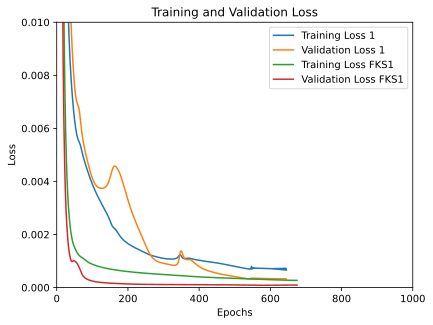

In [40]:
# Access the loss values from the training history.
mm = 1
train_loss = history[mm].history['loss']
val_loss = history[mm].history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss '+str(mm))
plt.plot(epochs, val_loss, label='Validation Loss '+str(mm))

train_loss = historyFKS[mm].history['loss']
val_loss = historyFKS[mm].history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss FKS'+str(mm))
plt.plot(epochs, val_loss, label='Validation Loss FKS'+str(mm))

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.01)
plt.xlim(0,1000)
plt.legend()

In [23]:
mom_test = mom_data[n_training_points:n_training_points+n_test_points]
amp_test = amp_data[n_training_points:n_training_points+n_test_points]

In [24]:
inv_test = np.array([momenta2invariants(mm) for mm in mom_test])
inv_test_stdized = standardize(inv_test[:,1:], inv_ave, inv_std)

In [25]:
amp_preds = [np.array(
    destandardize(model[mm].predict(inv_test_stdized), amp_ave, amp_std)
).reshape(-1) for mm in range(n_ensemble)]

28125/28125 [==============================] - 17s 592us/step


In [26]:
amp_pred = np.mean(amp_preds,axis=0)
amp_pred_err = np.std(amp_preds,axis=0)

In [27]:
ampFKS_preds = [np.array(
    destandardize(modelFKS[mm].predict(inv_test_stdized), ampFKS_ave, ampFKS_std)
) for mm in range(n_ensemble)]

28125/28125 [==============================] - 17s 602us/step


In [28]:
ampFKS_pred = np.mean(np.sum(ampFKS_preds,axis=2),axis=0)
ampFKS_pred_err = np.std(np.sum(ampFKS_preds,axis=2),axis=0)

In [29]:
acc = 2.*(amp_pred-amp_test)/(amp_pred+amp_test)
accFKS = 2.*(ampFKS_pred-amp_test)/(ampFKS_pred+amp_test)

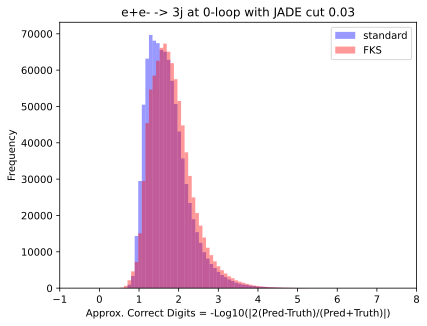

In [30]:
logacc = -np.log10(abs(acc))
logaccFKS = -np.log10(abs(accFKS))

mybins = np.histogram_bin_edges(logacc, bins=100, range=(-1,8))
plt.hist(logacc, density=False, bins=mybins, color='b', alpha=0.4, label='standard')
plt.hist(logaccFKS, density=False, bins=mybins, color='r', alpha=0.4, label='FKS')
plt.xlim([-1,8])
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.xlabel('Approx. Correct Digits = -Log10(|2(Pred-Truth)/(Pred+Truth)|)')
plt.ylabel('Frequency');
plt.legend()

In [31]:
outtest = np.transpose(np.array([amp_test,np.abs(amp_pred-amp_test),amp_pred_err]))
outtestFKS = np.transpose(np.array([amp_test,np.abs(ampFKS_pred-amp_test),ampFKS_pred_err]))

In [32]:
outtest_sample = outtest[np.random.choice(outtest.shape[0], size=5000, replace=False)]
outtestFKS_sample = outtestFKS[np.random.choice(outtestFKS.shape[0], size=5000, replace=False)]

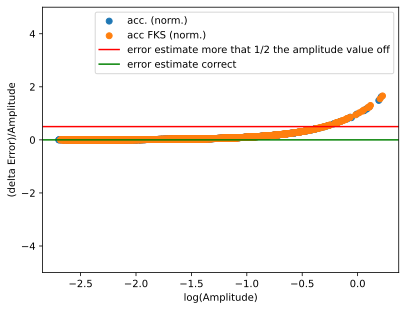

In [33]:
plt.scatter(np.log10(outtest_sample[:,0]),np.abs(2.*(outtest_sample[:,0]-outtest_sample[:,1])/(outtest_sample[:,0]+outtest_sample[:,1])),label='acc. (norm.)')
plt.scatter(np.log10(outtestFKS_sample[:,0]),np.abs(2.*(outtestFKS_sample[:,0]-outtestFKS_sample[:,1])/(outtestFKS_sample[:,0]+outtestFKS_sample[:,1])),label='acc FKS (norm.)')
plt.ylim([-5,5])
plt.xlabel('log(Amplitude)')
plt.ylabel('accuracy')
plt.legend()

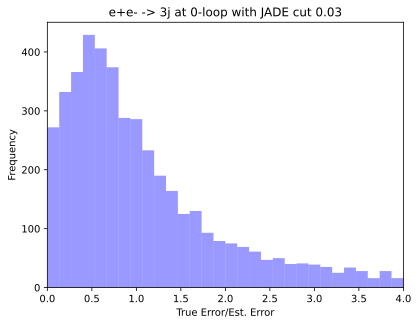

In [36]:
err_ratio = outtest_sample[:,1]/outtest_sample[:,2]
mybins = np.histogram_bin_edges(err_ratio, bins=30, range=(0,4))
plt.hist(err_ratio, density=False, bins=mybins, color='b', alpha=0.4)
plt.xlim([0,4])
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.xlabel('True Error/Est. Error')
plt.ylabel('Frequency');

In [37]:
# total cross section for the test sample
print("sigma_test = ",np.mean(amp_test),"+/-",np.std(amp_test)/np.sqrt(len(amp_test)))
sigma_ref = np.mean(amp_test)

# total cross section using ensemble model
print("sigma_pred = ",np.mean(amp_pred),"+/-",np.std(amp_pred)/np.sqrt(len(amp_pred)))
# total cross section using FKS model
print("sigma_pred_FKS = ",np.mean(ampFKS_pred),"+/-",np.std(ampFKS_pred)/np.sqrt(len(ampFKS_pred)))

sigma_test =  0.03634894316403577 +/- 9.051936837964022e-05
sigma_pred =  0.03640438 +/- 8.931825620541871e-05
sigma_pred_FKS =  0.03630347 +/- 9.086445756658472e-05


In [38]:
stepsize = 10000

xs_NJ = [[np.mean(amp_test[0:stepsize*i]), np.std(amp_test[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]
xs_NN = [[np.mean(amp_pred[0:stepsize*i]), np.std(amp_pred[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]
xs_NN_FKS = [[np.mean(ampFKS_pred[0:stepsize*i]), np.std(ampFKS_pred[0:stepsize*i])] for i in range(1,int(n_test_points/stepsize))]

xs_NJ = np.array(xs_NJ)
xs_NN = np.array(xs_NN)
xs_NN_FKS = np.array(xs_NN_FKS)